In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os, sys, json, random, string, re
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS

import nltk
#nltk.download('stopwords')

files = os.listdir("./data")

json_data = pd.DataFrame(columns=['src_lang', 'text', 'file_name', 'meme_id'])

for index, js in enumerate(files):
    with open(os.path.join('./data', js)) as json_file:
        json_text = json.load(json_file)
        src_lang = json_text['src_lang']
        text = json_text['text']
        file_name = json_text['file_name']
        meme_id = json_text['id']
        json_data.loc[index] = [src_lang, text, file_name, meme_id]

def clean_column(data):
    if data is not None:
        stopword_list = stopwords.words('english')
        data = data.lower()
        data = re.sub(r"\n", " ", data)
        data = re.sub(r"i'm", "i am", data)
        data = re.sub(r"\'re", " are", data)
        data = re.sub(r"\'d", " would", data)
        data = re.sub(r"\'ve", " have", data)
        data = re.sub(r"\'ll", " will", data)
        data = re.sub(r"can't", "cannot", data)
        data = re.sub(r"thats", "that is", data)
        data = re.sub(r"that's", "that is", data)
        data = re.sub(r"hes", "he is", data)
        data = re.sub(r"shes", "she is", data)
        data = re.sub(r"\'s", " is", data)
        data = re.sub(r"n't", " not", data)
        data = re.sub(r"ur", "you are", data)
        data = re.sub(r"u r", "you are", data)
        data = re.sub(r"[0-9]+", "", data)
        data = re.sub(r"[^\w\s]", "", data)
        return data

json_data['text'] = json_data['text'].apply(clean_column)
print(len(json_data))



3031


In [109]:
stopwords = set(STOPWORDS)
stopwords.add('will')
stopwords.add('yoyou')
stopwords.add('rdankmemes')
stopwords.add('meme')
stopwords.add('memes')
#stopwords.add('hoyou')

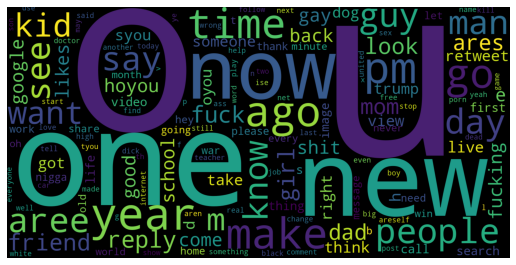

In [110]:
wordcloud = WordCloud(
    collocations = False,
    width=1600, height=800,
    stopwords=stopwords,
    max_words=150,
    random_state=42
).generate(' '.join(json_data['text']))


print(wordcloud)
plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [111]:
stemmer = PorterStemmer()
def stemming_tokenizer(input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words

In [112]:
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokensize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [113]:
data = json_data['text']
tf_idf_vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=5000)
tf_idf = tf_idf_vectorizer.fit_transform(data)
tf_idf_norm = normalize(tf_idf)
tf_idf_arr = tf_idf_norm.toarray()
pd.DataFrame(tf_idf_arr, columns=tf_idf_vectorizer.get_feature_names()).head()

/home/skuretski/anaconda3/envs/cs410/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


,aa,aaa,aaaaa,aabbccddee,abc,ability,able,abortion,abs,absolutely,...,吕口,変態,大志田橋,幽like,文a,新rldd,曾ill,民ea,習大,自eac
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CPU times: user 531 ms, sys: 46.9 ms, total: 578 ms
Wall time: 86.7 ms


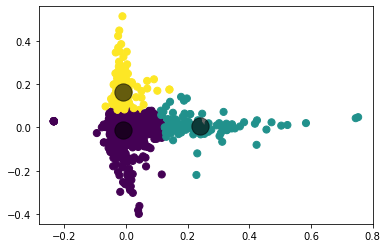

In [129]:
class Kmeans:
    def __init__(self, k, seed=None, max_iter=100):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
    def init_centroids(self, data):
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        return self.centroids
    
    def assign_clusters(self, data):
        if data.ndim == 1:
            data = reshape(-1,1)
        dist_to_centroid = pairwise_distances(data, self.centroids, metric="euclidean")
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        return self.cluster_labels
    
    def update_centroids(self, data):
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)]) 
        return self.centroids

num_clusters = 3

sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_arr)

kmeans = KMeans(n_clusters= num_clusters, max_iter=600, algorithm = 'auto')
%time fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1],c=prediction ,s=50, cmap='viridis')

centers2 = fitted.cluster_centers_
plt.scatter(centers2[:, 0], centers2[:, 1],c='black', s=300, alpha=0.6);

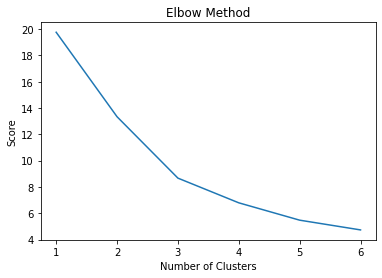

In [130]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score = [i*-1 for i in score]

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [ ]:
for n in range num_clusters:
    fig, (ax1, ax2) = plt.subplots(1,2)
    fit.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len()])
    

In [125]:
def get_top_features_cluster(tf_idf_arr, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_arr[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_idf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_arr, prediction, 20)

<AxesSubplot:xlabel='score', ylabel='features'>

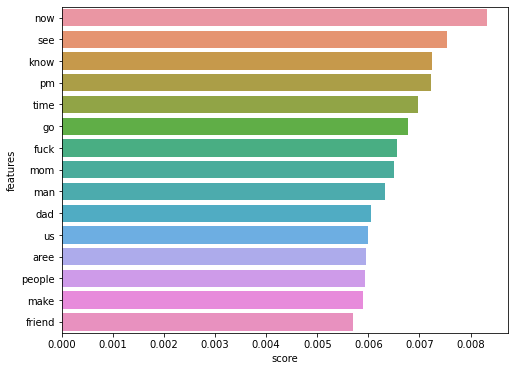

In [126]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[0][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

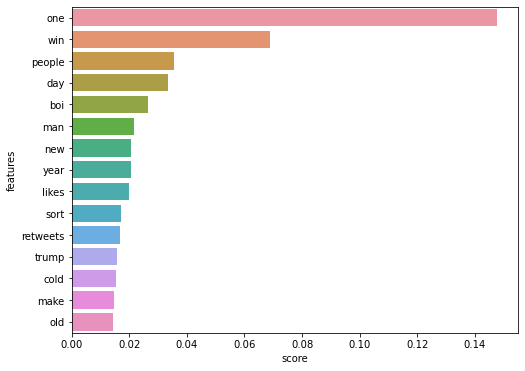

In [127]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[1][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

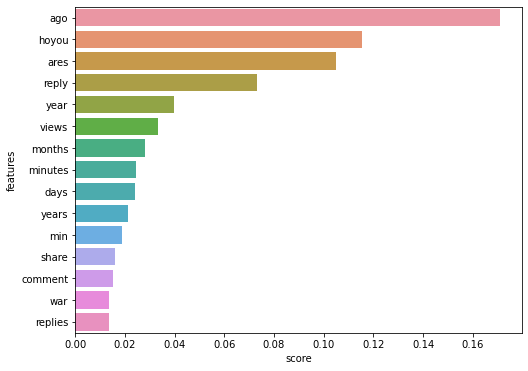

In [128]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[2][:15])

<AxesSubplot:xlabel='score', ylabel='features'>

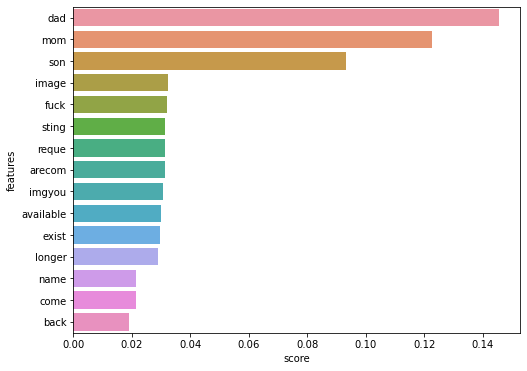

In [122]:
plt.figure(figsize=(8,6))
sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[3][:15])